# Factor Selection

In [1]:
from WindPy import w
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.api import het_white, het_breuschpagan
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.tsa.seasonal import STL

24.2.0.60020


In [2]:
w.start()

Wind.Cosmos.Base V1.7 compiled time is Apr 17 2023, BuildType:Release, CPUArch:X64, GCC Version:Apple LLVM 13.0.0 (clang-1300.0.29.30)
Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2021 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [20]:
start_date = "2008-12-01" # actually from 2010, extract data for preprocessing
end_date = "2024-05-31"

In [21]:
# takes a dict of indicators and their corresponding ticker in Wind to
# create a DataFrame containing the data extracted from Wind API
def extract_inds(inds):
    df = pd.DataFrame()
    for ind in inds:
        raw = w.edb(inds[ind], start_date, end_date)
        # Extract data from the Wind API response
        times = raw.Times
        data = raw.Data[0]
        # Convert times to pandas datetime format
        times = pd.to_datetime([str(time) for time in times], format="%Y-%m-%d")
        
        # Create a temporary DataFrame for the current indicator
        temp_df = pd.DataFrame(data, index=times, columns=[ind])
        
        # Combine the temporary DataFrame with the main DataFrame
        if df.empty:
            df = temp_df
        else:
            df = df.join(temp_df, how='outer')
    return df

In [22]:
def lag_data(df, periods=1):
    df_lagged = df.shift(periods)
    df_lagged = df_lagged.iloc[periods:]  # Remove the first rows
    return df_lagged

In [23]:
# STL seasonality processing
def apply_stl(df, columns, seasonal=13):
    df_adjusted = df.copy()
    for column in columns:
        stl = STL(df[column], seasonal=seasonal)
        result = stl.fit()
        df_adjusted[column] = result.seasonal  # Replace with seasonally adjusted component
    return df_adjusted

In [41]:
# Logarithmic YoY Change Processing
def logyoy(df, columns):
    df_log_yoy = df.copy()
    for column in columns:
        df_log_yoy[column] = np.log(df[column] / df[column].shift(12)) * 100
    df_log_yoy = df_log_yoy.iloc[12:]  # Remove the first 12 rows where the shift operation would result in NaN
    return df_log_yoy

In [42]:
# Get USD/CNH Exchange Rate
fx_data = w.edb("M0000185", "2009-01-01", end_date, Period="M")
# Parse the data
times = fx_data.Times
data = fx_data.Data[0]
times = pd.to_datetime([str(time) for time in times], format="%Y-%m-%d")

# Construct the DataFrame
df_forex = pd.DataFrame(data, index=times, columns=["USD/CNY Central Parity Rate"])
df_forex = logyoy(df_forex, df_forex.columns)

# Display the DataFrame
df_forex

,USD/CNY Central Parity Rate
2010-01-29,-0.160995
2010-02-26,-0.160998
2010-03-31,-0.140534
2010-04-30,0.019046
2010-05-31,-0.064420
...,...
2024-01-31,4.956187
2024-02-29,2.158669
2024-03-29,3.197878
2024-04-30,2.598808


In [43]:
# for factor selection, regress on the exchang rate to observe Beta, T-Value, and R-Squared
# and record the median values after 1000 iterations
def regress(indicator_df, forex_df, target_column='USD/CNY Central Parity Rate', n_iterations=1000, min_period_length=24):
    # Initialize a DataFrame to store regression results
    df_forex.index = indicator_df.index
    results = []

    for i in range(n_iterations):
        # Resample with replacement
        sample_indices = np.random.choice(indicator_df.index, size=len(indicator_df), replace=True)
        sample_growth_df = indicator_df.loc[sample_indices]
        sample_forex_df = forex_df.loc[sample_indices]
        
        # Randomly select start and end dates
        start_idx = np.random.randint(0, len(sample_growth_df) - min_period_length)
        end_idx = start_idx + min_period_length
        
        # Subset the data to ensure period longer than 2 years
        sample_growth_period = sample_growth_df.iloc[start_idx:end_idx]
        sample_forex_period = sample_forex_df.iloc[start_idx:end_idx]
        
        # Perform regression for each indicator
        for indicator in indicator_df.columns:
            X = sample_growth_period[[indicator]]
            X = sm.add_constant(X)
            y = sample_forex_period[target_column]
            
            model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
            beta = model.params[indicator]
            t_value = model.tvalues[indicator]
            r_squared = model.rsquared
            
            # Append the results
            results.append({
                'Indicator': indicator,
                'Beta': beta,
                'T-Value': t_value,
                'R-Squared(%)': r_squared * 100  # Convert to percentage
            })
            
    # Convert results to DataFrame
    growth_results_df = pd.DataFrame(results)

    # Compute median values
    growth_median_results = growth_results_df.groupby('Indicator').median().reset_index()

    # Format the median results
    growth_median_results['Beta'] = growth_median_results['Beta'].map("{:.2f}".format)
    growth_median_results['T-Value'] = growth_median_results['T-Value'].map("{:.2f}".format)
    growth_median_results['R-Squared(%)'] = growth_median_results['R-Squared(%)'].map("{:.2f}%".format)

    return growth_median_results

## Growth Factor

In [39]:
# consider key growth indicators for China
china_growth_inds = {
    # production method
    # general macro indicators
    'GDP_China(%)': 'M0039354',
    'Industrial_Growth(%)': 'M0000545',
    'PMI': 'M0017126',
    'PMI_manufacture': 'M0017127',
    'PMI_new_orders': 'M0017128',
    # by industry
    'electricity(%)': 'S0027013',
    'concrete(%)': 'S0027703',
    'steel(%)': 'S0027375',
    'automobile(%)': 'S0027908',
    'railroad_cargo(%)': 'S0036034',
    # expenditure method
    # investments
    'fixed_asset(%)': 'M0000273',
    'real_estate(%)': 'S0029657',
    'infrastructure(%)': 'M5440435',
    'manufacture(%)': 'M0000357',
    # consumption
    'retail(%)': 'M0001428',
    'automobile_sales(%)': 'S6114593',
    'tractor_sales(%)': 'S6002167',
    'commercial_RE_area(%)': 'S0073300',
    'commercial_RE_revenue(%)': 'S0049591',
    # net exports
    'import_export(%)': 'M0000605',
    'export(%)': 'M0000607',
    'import(%)': 'M0000609',
    'export_to_US(%)': 'M0008499',
    # income method
    'govt_revenue(%)': 'M0046169',
    'industrials_biz_income(%)': 'M0000555',
    'industrials_tot_profits(%)': 'M0000557'
}
# for standardizing the PMI data
china_nonyoy_cols = ['PMI', 'PMI_manufacture', 'PMI_new_orders']

In [44]:
# actual step retrieving data from Wind API
df_china_growth = extract_inds(china_growth_inds)
df_china_growth = lag_data(df_china_growth)  # lag data by 1 period
df_china_growth = logyoy(df_china_growth, china_nonyoy_cols)
df_china_growth = df_china_growth.bfill().interpolate(method="linear")  # interpolate missing values
df_china_growth = apply_stl(df_china_growth, df_china_growth.columns[1:], seasonal=13)
df_china_growth.head(10)


,GDP_China(%),Industrial_Growth(%),PMI,PMI_manufacture,PMI_new_orders,electricity(%),concrete(%),steel(%),automobile(%),railroad_cargo(%),...,tractor_sales(%),commercial_RE_area(%),commercial_RE_revenue(%),import_export(%),export(%),import(%),export_to_US(%),govt_revenue(%),industrials_biz_income(%),industrials_tot_profits(%)
2010-01-31,11.9,-0.096970,5.846520,9.114466,9.709468,0.601227,-3.171591,0.625182,19.132004,1.014852,...,7.264556,1.598908,3.587245,-5.436913,-7.867885,-2.066218,-8.875960,-7.074421,1.271387,4.131011
2010-02-28,12.2,2.783520,2.562208,3.913312,3.225228,6.630864,8.592328,5.101400,26.032968,1.212978,...,46.177350,4.171527,7.164816,3.980726,-1.650477,14.438124,0.167588,3.291982,-1.650102,2.322865
2010-03-31,12.2,0.323882,0.274622,0.462007,-0.211966,-1.960675,-5.596200,1.990873,-7.204441,0.227684,...,-19.095841,5.233529,8.981636,-0.492400,0.768446,-3.225484,0.678645,1.876411,-0.776474,6.137579
2010-04-30,12.2,0.471551,-1.408475,-2.927482,-1.902551,0.754225,1.236998,2.104911,-3.118176,0.805208,...,12.352918,3.482161,4.557782,1.135167,-1.911502,4.450236,0.136462,2.227174,-0.722639,-5.372916
2010-05-31,10.8,-0.273816,-1.526515,-2.115125,-2.480644,0.779088,0.088304,3.276847,-8.572519,-0.218718,...,0.387010,0.731982,1.376766,-0.202149,0.511089,-1.812951,0.027063,1.657076,-0.592664,-2.811661
2010-06-30,10.8,-0.407686,-1.293221,-1.576595,-2.612645,0.575272,0.129788,1.702735,-7.269195,-0.427904,...,4.947086,-1.558555,-2.483254,4.114401,5.766158,1.343908,1.115206,1.082689,-0.014208,-0.174990
2010-07-31,10.8,-0.729037,-1.287622,-1.752930,-2.124038,-0.935082,0.042277,-1.700767,-7.755009,-1.470858,...,-6.973331,-2.541324,-4.412250,-0.999995,2.650109,-5.773855,1.377295,0.133510,-1.131388,-6.994809
2010-08-31,9.9,-0.719035,-0.891482,-1.643023,-1.379471,-0.843911,0.449640,-1.843696,-7.869350,-2.053152,...,-11.450918,-3.347716,-5.273329,-2.195537,1.002463,-6.217931,0.931240,-0.417073,-0.480287,-4.060486
2010-09-30,9.9,-0.515715,-0.854823,-1.514394,-0.751154,-0.352534,-1.426724,-3.093636,-4.937814,-1.706694,...,-11.718382,-3.411548,-5.254498,1.174948,2.134809,-0.341625,1.284273,-0.734189,0.271311,-0.970916
2010-10-31,9.9,-0.310241,-0.114792,-0.218874,0.250744,-1.706833,-0.997469,-2.974243,-2.319353,0.474085,...,-9.962740,-2.042651,-3.079432,-2.870760,-2.210340,-3.801352,0.873300,-0.909689,0.434366,-0.140897


In [45]:
china_growth_ctrb = regress(df_china_growth, df_forex)
china_growth_ctrb

,Indicator,Beta,T-Value,R-Squared(%)
0,GDP_China(%),-0.68,-3.50,21.27%
1,Industrial_Growth(%),-0.03,-0.03,2.82%
2,PMI,0.02,0.03,1.63%
3,PMI_manufacture,0.03,0.07,1.69%
4,PMI_new_orders,0.02,0.03,1.52%
5,automobile(%),0.01,0.05,1.22%
6,automobile_sales(%),-0.01,-0.08,3.01%
7,commercial_RE_area(%),-0.01,-0.02,2.40%
8,commercial_RE_revenue(%),0.00,0.00,2.29%
9,concrete(%),-0.02,-0.04,1.87%


In [46]:
us_growth_inds = {
        # production method
        # general macro indicators
        'GDP_US': 'G1112986',
        'industrial production': 'G1109285',
        'PMI': 'G0002323',
        'PMI_output': 'G0008346',
        'PMI_new_order': 'G0008345', 
        # by industry
        'electricity': 'G1130815',
        'concrete_rebar': 'D5715886',
        'crude_steel': 'S5709965',
        'automobile': 'G1121656',
        # investment
        'real_estate_loans': 'T7212500',
        # consumption
        'new_house_sales': 'G0003650',
        'auto_sales': 'G1121638',
        'food_and_retail_sales': 'G1113053',
        'import_export': 'G1113168',
        'export': 'G1113166',
        'import': 'G1100355',
        'export_to_China': 'G1101044'
}
us_nonyoy_cols = ['PMI', 'PMI_output', 'PMI_new_order', 'electricity', 'concrete_rebar', 'automobile', 'real_estate_loans', 'new_house_sales', 'auto_sales', 'export_to_China']

In [47]:
df_us_growth = extract_inds(us_growth_inds)
df_us_growth = lag_data(df_us_growth)  # lag data by 1 period
df_us_growth = logyoy(df_us_growth, us_nonyoy_cols)
df_us_growth = df_us_growth.bfill().interpolate(method="linear")  # interpolate missing values
df_us_growth = apply_stl(df_us_growth, df_us_growth.columns[1:], seasonal=13)
df_us_growth.head(10)

,GDP_US,industrial production,PMI,PMI_output,PMI_new_order,electricity,concrete_rebar,crude_steel,automobile,real_estate_loans,new_house_sales,auto_sales,food_and_retail_sales,import_export,export,import,export_to_China
2010-01-31,0.1055,-2.104912,0.877862,9.709406,15.121765,-1.940567,1.104925,-8.482444,-22.870765,0.322016,2.350429,0.015133,-0.409410,17.082833,-4.496115,-6.621462,1.352297
2010-02-28,1.7450,-1.121366,0.701872,5.403047,3.973833,-1.623970,1.750158,-7.912877,11.278686,0.312563,6.751234,1.801923,-1.358080,7.143253,-1.732862,-3.082494,3.629907
2010-03-31,1.7450,-0.829593,2.318728,1.278723,5.869085,0.244224,1.242178,-5.860049,4.862559,0.231733,1.828286,5.836068,0.398335,-3.677337,-2.148353,-0.438117,0.083668
2010-04-30,1.7450,-0.005747,3.897626,4.151603,0.922068,-0.590848,1.237119,3.019088,1.215648,0.105976,5.543896,6.179274,1.855596,-4.329208,0.929023,1.191207,-2.731628
2010-05-31,2.9141,0.582113,2.420588,5.191102,-1.579631,-0.555824,0.254287,9.602000,10.797482,0.009025,7.039080,3.953640,0.894647,-2.598684,2.661588,1.938611,-3.054900
2010-06-30,2.9141,1.115886,1.425975,2.988254,-2.226063,0.468411,-0.924842,9.576427,8.977320,-0.130429,0.264608,1.482401,0.392128,-14.095850,2.232160,3.556577,-3.070446
2010-07-31,2.9141,1.205672,-0.560900,-5.887380,-2.604664,0.610198,-1.797872,8.281168,7.528864,-0.126882,-2.372781,0.919676,-0.685235,-5.172639,1.585113,2.942933,-3.370240
2010-08-31,3.3443,0.755645,-2.378998,-7.013156,-4.421201,2.071841,-1.791418,0.559381,-0.308168,-0.121014,-6.140113,-7.509788,-0.957430,2.129256,0.173301,0.557158,0.565127
2010-09-30,3.3443,0.294989,-3.155250,-6.628876,-8.535726,0.420906,-1.526749,-0.882495,-2.863363,-0.140198,-6.339214,-15.573241,-0.557575,-4.174901,1.544052,1.489362,0.402647
2010-10-31,3.3443,-0.014635,-2.464516,-3.162116,-4.865150,0.532730,-0.261031,-3.942923,-7.879331,-0.132695,-2.338738,2.387571,0.279172,3.589158,-0.225256,-0.237553,0.013515


In [48]:
us_growth_ctrb = regress(df_us_growth, df_forex)
us_growth_ctrb

,Indicator,Beta,T-Value,R-Squared(%)
0,GDP_US,-0.52,-1.39,5.48%
1,PMI,-0.07,-0.09,1.81%
2,PMI_new_order,-0.01,-0.03,1.37%
3,PMI_output,-0.04,-0.14,1.74%
4,auto_sales,-0.06,-0.21,1.79%
5,automobile,-0.01,-0.06,1.62%
6,concrete_rebar,-0.16,-0.14,1.57%
7,crude_steel,-0.01,-0.02,1.42%
8,electricity,0.02,0.01,1.60%
9,export,0.01,0.02,2.15%


It appears that of all the indicators picked intended to represent growth in China and US's economy, most of the indicators have very little contributions to the movement of USD/CNH. China's GDP appears to have a more direct impact, as its T-value indicates significance and has a relatively high R-squared value of roughly 20%, thus we select China's GDP as a component of our growth factor. Meanwhile, the US GDP appears less impactful than its counterpart but is still the most influential indicator amongst the US indicators. Hence, we also select the US GDP as a component of the growth factor. 

Both China and US GDP having slight negative beta on the exchange rate (USD/CNY) can be explained by considering the economic dynamics between the two countries. In China's case, a growing Chinese economy might lead to increased export which prompts RMB to appreciate against USD, while a growing US economy often leads to increased imports, which increases demands for Chinese goods and thereby exerts downward pressure on USD/CNH exchange rate.

In [49]:
# combine the factors based on Inverse Volatility Weights
invvol_cn = 1 / df_china_growth["GDP_China(%)"].std()
invvol_us = 1 / df_us_growth["GDP_US"].std()
total_invvol = invvol_cn + invvol_us
weight_cn = invvol_cn / total_invvol
weight_us = invvol_us / total_invvol
growth = (weight_us * df_us_growth["GDP_US"]) + (weight_cn * df_china_growth["GDP_China(%)"])
growth


2010-01-31    4.878288
2010-02-28    5.975743
2010-03-31    5.975743
2010-04-30    5.975743
2010-05-31    6.105226
                ...   
2024-01-31    3.970389
2024-02-29    3.861069
2024-03-31    3.861069
2024-04-30    3.861069
2024-05-31    3.861069
Length: 173, dtype: float64

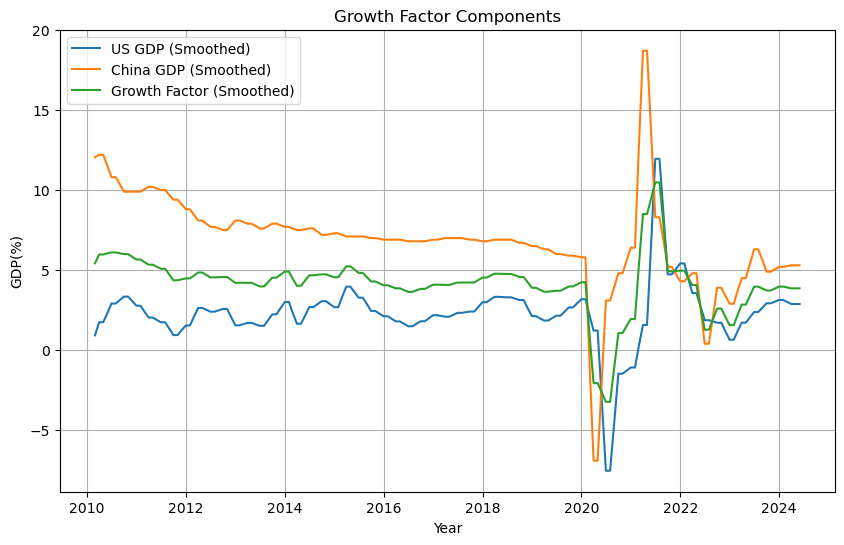

In [51]:
# Calculate rolling average (smoothing)
window_size = 2  # You can adjust the window size for more or less smoothing
smoothed_us_gdp = df_us_growth["GDP_US"].rolling(window=window_size).mean()
smoothed_china_gdp = df_china_growth["GDP_China(%)"].rolling(window=window_size).mean()
smoothed_growth = growth.rolling(window=window_size).mean()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(smoothed_us_gdp.index, smoothed_us_gdp, label='US GDP (Smoothed)')
plt.plot(smoothed_china_gdp.index, smoothed_china_gdp, label='China GDP (Smoothed)')
plt.plot(smoothed_growth.index, smoothed_growth, label='Growth Factor (Smoothed)')
plt.xlabel('Year')
plt.ylabel('GDP(%)')
plt.title('Growth Factor Components')
plt.legend()
plt.grid(True)
plt.show()

## Inflation Factor